In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder

import xgboost as xgb
import lightgbm as lgb


In [4]:
# Load dataset
df = pd.read_csv("sales_data.csv")

# Display top rows
print(df.head())
print(df.info())
print(df.describe())


         Date Store ID Product ID     Category Region  Inventory Level  \
0  2022-01-01     S001      P0001  Electronics  North              195   
1  2022-01-01     S001      P0002     Clothing  North              117   
2  2022-01-01     S001      P0003     Clothing  North              247   
3  2022-01-01     S001      P0004  Electronics  North              139   
4  2022-01-01     S001      P0005    Groceries  North              152   

   Units Sold  Units Ordered  Price  Discount Weather Condition  Promotion  \
0         102            252  72.72         5             Snowy          0   
1         117            249  80.16        15             Snowy          1   
2         114            612  62.94        10             Snowy          1   
3          45            102  87.63        10             Snowy          0   
4          65            271  54.41         0             Snowy          0   

   Competitor Pricing Seasonality  Epidemic  Demand  
0               85.73      Winte

In [5]:
# Check for missing values
print(df.isnull().sum())

# Example cleaning:
df['Date'] = pd.to_datetime(df['Date'])
df.fillna({
    'Discount': 0,
    'Promotion': 0,
    'Epidemic': 0
}, inplace=True)

# Drop duplicates if any
df.drop_duplicates(inplace=True)


Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Price                 0
Discount              0
Weather Condition     0
Promotion             0
Competitor Pricing    0
Seasonality           0
Epidemic              0
Demand                0
dtype: int64


In [6]:
# Extract date features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Example lag feature: previous day sales
df = df.sort_values(['Store ID', 'Product ID', 'Date'])
df['Lag_1'] = df.groupby(['Store ID', 'Product ID'])['Units Ordered'].shift(1)
df['Lag_7'] = df.groupby(['Store ID', 'Product ID'])['Units Ordered'].shift(7)

# Fill missing lags
df.fillna(0, inplace=True)


In [7]:
# Label encoding for categorical features
cat_cols = ['Category', 'Region', 'Weather Condition', 'Promotion', 'Seasonality']

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))


In [8]:
from sklearn.preprocessing import LabelEncoder

# Make sure both IDs are strings
df['Store ID'] = df['Store ID'].astype(str)
df['Product ID'] = df['Product ID'].astype(str)

# Encode them numerically
le_store = LabelEncoder()
df['Store ID'] = le_store.fit_transform(df['Store ID'])

le_product = LabelEncoder()
df['Product ID'] = le_product.fit_transform(df['Product ID'])

# Check dtypes again
print(df.dtypes)


Date                  datetime64[ns]
Store ID                       int64
Product ID                     int64
Category                       int64
Region                         int64
Inventory Level                int64
Units Sold                     int64
Units Ordered                  int64
Price                        float64
Discount                       int64
Weather Condition              int64
Promotion                      int64
Competitor Pricing           float64
Seasonality                    int64
Epidemic                       int64
Demand                         int64
Year                           int32
Month                          int32
Day                            int32
DayOfWeek                      int32
Lag_1                        float64
Lag_7                        float64
dtype: object


In [9]:
# Features and target
X = df.drop(columns=['Demand', 'Date'])  # assuming 'Demand' is the target column
y = df['Demand']

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [10]:
# Features and target
X = df.drop(columns=['Demand', 'Date'])
y = df['Demand']

# Split data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Sanity check: All features numeric
print(X_train.dtypes)


Store ID                int64
Product ID              int64
Category                int64
Region                  int64
Inventory Level         int64
Units Sold              int64
Units Ordered           int64
Price                 float64
Discount                int64
Weather Condition       int64
Promotion               int64
Competitor Pricing    float64
Seasonality             int64
Epidemic                int64
Year                    int32
Month                   int32
Day                     int32
DayOfWeek               int32
Lag_1                 float64
Lag_7                 float64
dtype: object


In [11]:
import lightgbm as lgb

lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)

lgb_model.fit(X_train, y_train)
y_pred = lgb_model.predict(X_test)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007763 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1893
[LightGBM] [Info] Number of data points in the train set: 60800, number of used features: 20
[LightGBM] [Info] Start training from score 104.355526


In [12]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


MAE: 11.29
RMSE: 14.83
R² Score: 0.90


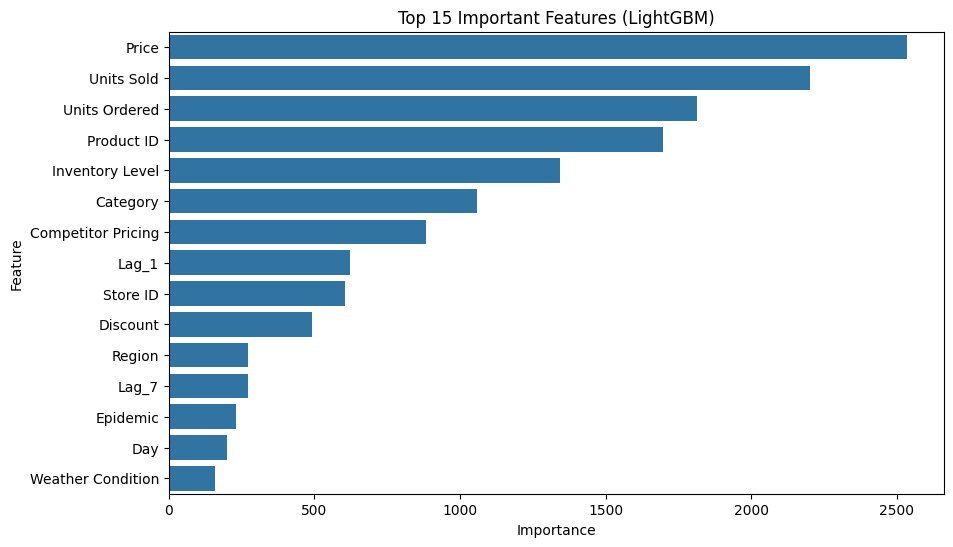

In [13]:
# Feature importance for LightGBM model
importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(data=importance.head(15), x='Importance', y='Feature')
plt.title("Top 15 Important Features (LightGBM)")
plt.show()


In [14]:
import pandas as pd

# Example: make predictions for the next 7 days for one product and one store
future_dates = pd.date_range(start=df['Date'].max(), periods=7, freq='D')

# Build future dataframe with same feature structure
future_df = pd.DataFrame({
    'Store ID': [0]*7,       # example store (numeric-encoded)
    'Product ID': [0]*7,     # example product (numeric-encoded)
    'Category': [1]*7,
    'Region': [2]*7,
    'Inventory Level': [100]*7,
    'Units Sold': [0]*7,
    'Units Ordered': [0]*7,
    'Price': [50]*7,
    'Discount': [0]*7,
    'Weather Condition': [1]*7,
    'Promotion': [0]*7,
    'Competitor Pricing': [45]*7,
    'Seasonality': [1]*7,
    'Epidemic': [0]*7,
    'Year': future_dates.year,
    'Month': future_dates.month,
    'Day': future_dates.day,
    'DayOfWeek': future_dates.dayofweek,
    'Lag_1': [0]*7,
    'Lag_7': [0]*7
})

# Predict using your trained model (choose the correct model)
future_predictions = lgb_model.predict(future_df)

print(future_predictions)


[6.75371312 6.75371312 7.26519457 7.26519457 7.43510571 7.73955197
 7.81284425]


In [15]:
future_demand = lgb_model.predict(future_df)
print(future_demand)


[6.75371312 6.75371312 7.26519457 7.26519457 7.43510571 7.73955197
 7.81284425]


In [16]:
import joblib
joblib.dump(lgb_model, 'demand_forecast_model.pkl')


['demand_forecast_model.pkl']

In [17]:
import pickle

# Suppose lgb_model is your trained LightGBM model
with open("lgb_model.pkl", "wb") as f:
    pickle.dump(lgb_model, f)


In [18]:
lgb_model = lgb.LGBMRegressor(
    n_estimators=500,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42
)
lgb_model.fit(X_train, y_train)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003891 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1893
[LightGBM] [Info] Number of data points in the train set: 60800, number of used features: 20
[LightGBM] [Info] Start training from score 104.355526


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [19]:
import joblib

# Assuming your model variable is lgb_model
joblib.dump(lgb_model, "lgb_model.pkl")


['lgb_model.pkl']